First we will import the dataset and carry out the column type conversions and null handling that has already been detailed in the previous part.

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
loans_df = pd.read_csv('loan_payments.csv')

# Converting suitable columns to categorical data
from data_transform import DataTransform

loans_transform = DataTransform(loans_df)

loans_transform.to_category('term')
loans_transform.to_category('grade')
loans_transform.to_category('sub_grade')
loans_transform.to_category('employment_length')
loans_transform.to_category('home_ownership')
loans_transform.to_category('verification_status')
loans_transform.to_category('loan_status')
loans_transform.to_category('purpose')

# Converting suitable columns to datetime64
loans_transform.to_datetime('issue_date')
loans_transform.to_datetime('earliest_credit_line')
loans_transform.to_datetime('last_payment_date')
loans_transform.to_datetime('next_payment_date')
loans_transform.to_datetime('last_credit_pull_date')

# NULL handling
loans_df.dropna(axis='columns', thresh=27000, inplace=True)

loans_df.dropna(subset=['last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med'], inplace=True)

from dataframe_transform import DataFrameTransform

loans_df_transform = DataFrameTransform(loans_df)

loans_df_transform.impute_mode('term')
loans_df_transform.impute_mode('employment_length')
loans_df_transform.impute_median('funded_amount')
loans_df_transform.impute_median('int_rate')

c:\Users\Kyle\AiCore_practicals\EDA_finance_project\data_transform.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[column]  = pd.to_datetime(self.df[column])
c:\Users\Kyle\AiCore_practicals\EDA_finance_project\data_transform.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[column]  = pd.to_datetime(self.df[column])
c:\Users\Kyle\AiCore_practicals\EDA_finance_project\data_transform.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[column]  = pd.to_datetime(self.df[column])
c:\Users\Kyle\AiCore_practicals\EDA_finance_project\data_transform.

Now we will begin to draw insights from the data. We will query the data to check the current state of the loans.

<Axes: >

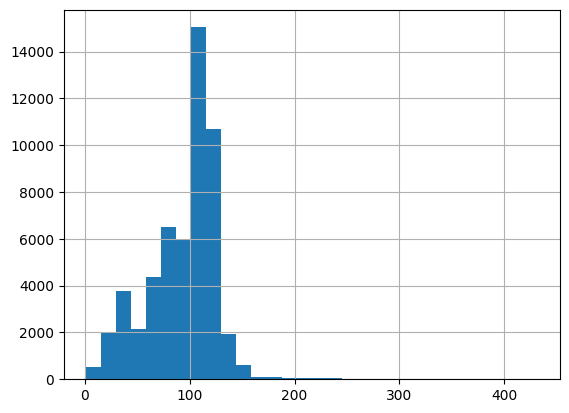

In [14]:
# Percentage of loans recovered against total amount funded
loans_df['recovered'] = loans_df.apply(lambda row: row.total_payment / row.funded_amount * 100, axis=1)
loans_df['recovered'].hist(bins=30)

<Axes: >

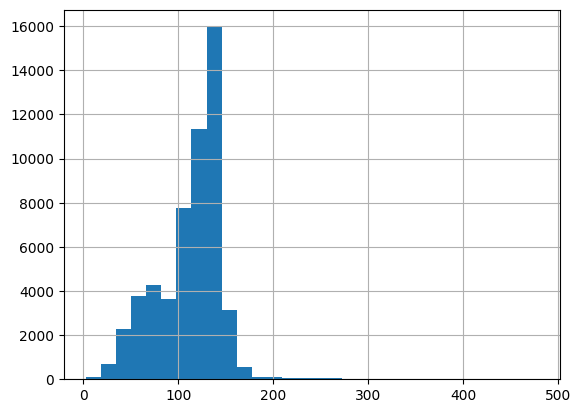

In [15]:
# Percentage of loans recovered up to 6 months in the future
loans_df['recovered_6mths'] = loans_df.apply(lambda row: (row.total_payment + row.instalment * 6) / row.funded_amount * 100, axis=1)
loans_df['recovered_6mths'].hist(bins=30)

Next, we will check what percentage of loans have been a loss to the company.

In [16]:
loans_df['loan_status'].value_counts()

loan_status
Fully Paid                                             27011
Current                                                19267
Charged Off                                             5500
Does not meet the credit policy. Status:Fully Paid       966
Late (31-120 days)                                       580
Does not meet the credit policy. Status:Charged Off      353
In Grace Period                                          265
Late (16-30 days)                                        106
Default                                                   52
Name: count, dtype: int64

In [17]:
loans_df['loan_status'].shape

(54100,)

In [19]:
percent_charged_off = (5500 + 353) / 54100 * 100
print(percent_charged_off)

10.818853974121996


In [26]:
# Total amount paid towards these loans before being charged off
charged_off = ['Charged Off', 'Does not meet the credit policy. Status:Charged Off']
mask = loans_df['loan_status'].isin(charged_off)
charged_off_df = loans_df[mask]
charged_off_df['total_payment'].sum()

39092575.243503466

Next we will calculate the loss in revenue that the loans marked as charged off would have generated if they had finished their term.

C:\Users\Kyle\AppData\Local\Temp\ipykernel_89144\773010113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_df['losses'] = charged_off_df.apply(lambda row: row.loan_amount - row.total_payment, axis=1)


<Axes: >

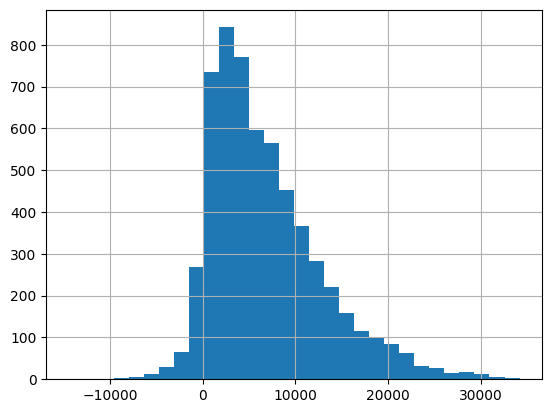

In [27]:
charged_off_df['losses'] = charged_off_df.apply(lambda row: row.loan_amount - row.total_payment, axis=1)
charged_off_df['losses'].hist(bins=30)

Next we will look at customers who are currently behind on their loan payments.

In [24]:
# Using loans_df['loan_status'].value_counts() from earilier
percent_late = (580 + 106) / 54100 * 100
print(percent_late)

1.268022181146026


In [25]:
# Loss incurred if the late customers were charged off
late = ['Late (31-120 days)', 'Late (16-30 days)']
mask = loans_df['loan_status'].isin(late)
late_df = loans_df[mask]
late_df['losses'] = late_df.apply(lambda row: row.loan_amount - row.total_payment, axis=1)
late_df['losses'].sum()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_89144\1836683565.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_df['losses'] = late_df.apply(lambda row: row.loan_amount - row.total_payment, axis=1)


3408775.05

Next we are going to explore the data to find possible indicators that a customer will be unable to pay the loan.

<Axes: xlabel='grade', ylabel='Count'>

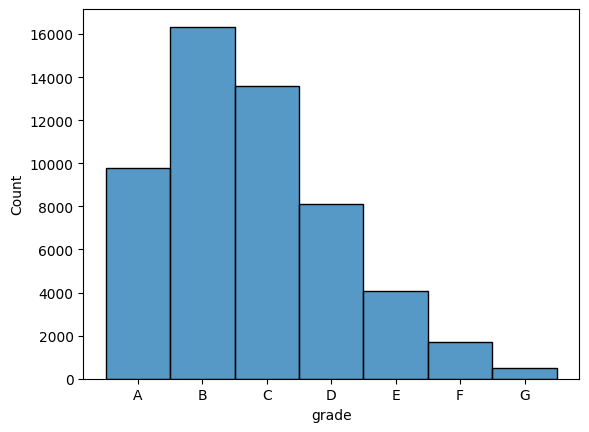

In [28]:
import seaborn as sns
# Distribution of grades across the whole dataset
sns.histplot(binwidth=0.5, x='grade', data=loans_df, stat="count")

<Axes: xlabel='grade', ylabel='Count'>

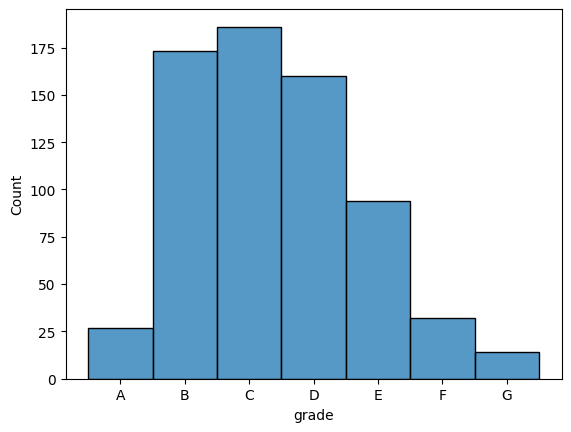

In [29]:
# Distribution of grades across those who are late on payments
sns.histplot(binwidth=0.5, x='grade', data=late_df, stat="count")

<Axes: xlabel='grade', ylabel='Count'>

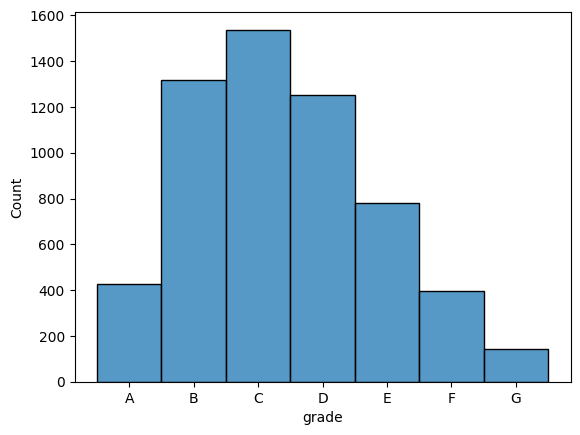

In [30]:
# Distribution of grades across those who have been charged off
sns.histplot(binwidth=0.5, x='grade', data=charged_off_df, stat="count")

Looking at the grade column, we can see that the distribution is very similar for customers who were already charged off and those who are currently late on payments. Comparing this to the entire dataset, it seems that the middle grades of C, D and E make up on a much bigger proportion of the loans for those who are stuggling to pay, while there is a lower proprtion of grade A loans where payment is behind.

<Axes: ylabel='purpose'>

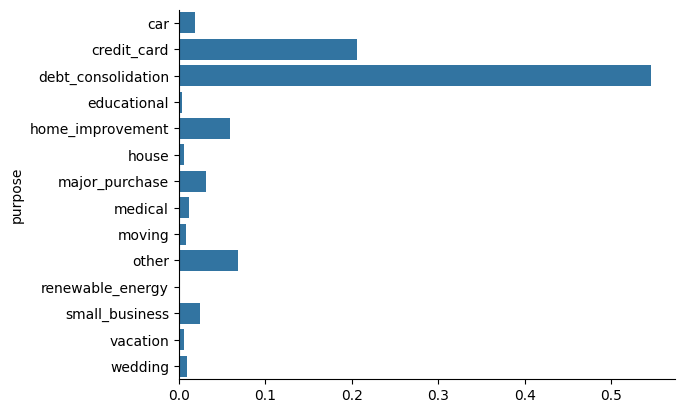

In [37]:
# Distribution of purpose across the whole dataset
probs = loans_df['purpose'].value_counts(normalize=True)
sns.barplot(y=probs.index, x=probs.values)

<Axes: ylabel='purpose'>

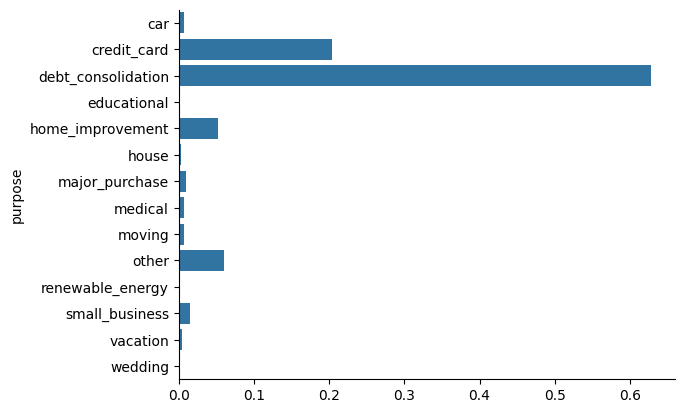

In [38]:
# Distribution of purpose across those who are late on payments
probs = late_df['purpose'].value_counts(normalize=True)
sns.barplot(y=probs.index, x=probs.values)

<Axes: ylabel='purpose'>

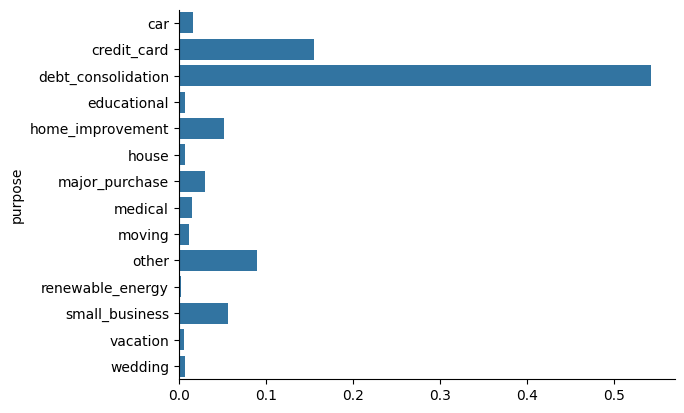

In [39]:
# Distribution of purpose across those who have been charged off
probs = charged_off_df['purpose'].value_counts(normalize=True)
sns.barplot(y=probs.index, x=probs.values)

Looking at the purpoose column, it seems that there is not a significant amount of difference between the distributions for the three different groups, so it seems that the purpose of the loan is not necessarily an indicator for how likely it is that the customer will be unable to pay.

<Axes: xlabel='home_ownership', ylabel='Count'>

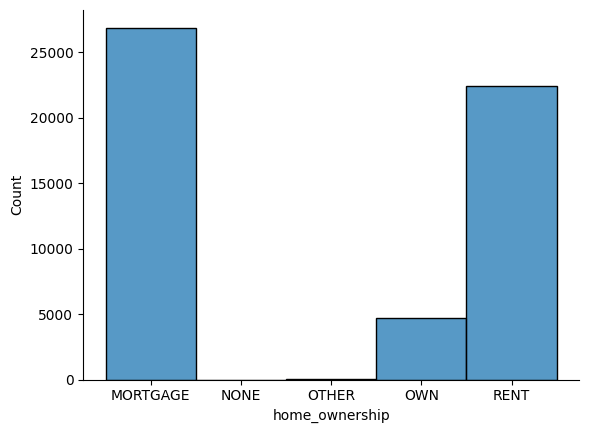

In [40]:
# Distribution of home ownership across the whole dataset
sns.histplot(binwidth=0.5, x='home_ownership', data=loans_df, stat="count")

<Axes: xlabel='home_ownership', ylabel='Count'>

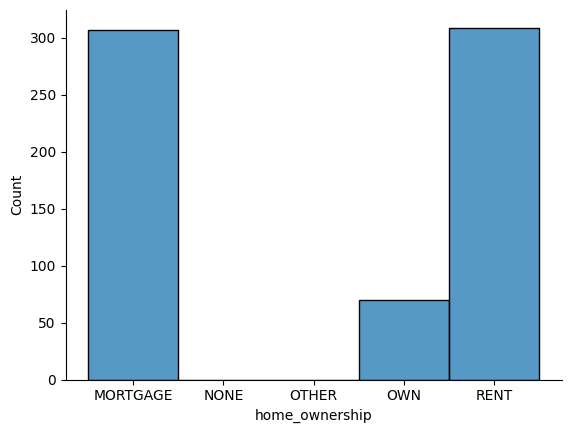

In [41]:
# Distribution of home ownership across those who are late on payments
sns.histplot(binwidth=0.5, x='home_ownership', data=late_df, stat="count")

<Axes: xlabel='home_ownership', ylabel='Count'>

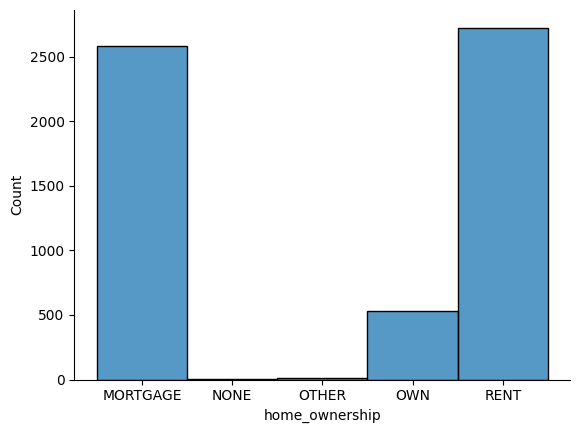

In [42]:
# Distribution of home ownership across those who have been charged off
sns.histplot(binwidth=0.5, x='home_ownership', data=charged_off_df, stat="count")

Looking at the home ownership column, there is a similar pattern between those who are late on payments and those who have been charge off, in that there was a greater proportion of customers who are renting accomodation, in comparison to the entire dataset. So this may be an indicator of how likely it is that a customer will be unable to pay.